# Lab 2. 利用Deep Q-Network訓練

大家好。歡迎各位再度回來增強式學習的世界。這一次，我們要更進化一點，利用深度網路來作為Q Function，達到比用Q-Table更好的效果。

首先，因為我們使用的是Google CoLab，為了能夠方便在這個環境上面顯示，我們先安裝一些必要的套件。

In [0]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [2]:
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1024x768x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1024x768x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt

這一個實驗，我們來玩一下小車車爬山坡的遊戲。這個遊戲的環境在這裡：https://github.com/openai/gym/wiki/MountainCar-v0

# 亂數策略玩遊戲
首先，我們還是用亂走來玩一下這個遊戲，看看會發生什麼事情。

Total reward: -200.0


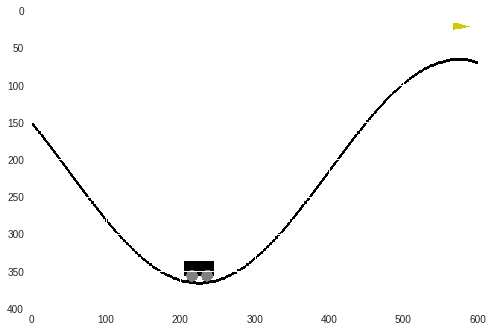

In [4]:
env = gym.make("MountainCar-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

rewards=0
for t in range(200):
  #亂數選一個動作
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  #print("reward:",reward,"done:",done)
  
  rewards+=reward
  #env.render()用來顯示結果
  screen = env.render(mode='rgb_array')
  #用matploblib畫出來
  if t%10==0:
      plt.imshow(screen)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())
    
  if done:
	  break  

ipythondisplay.clear_output(wait=True)
env.close()

print("Total reward:",rewards)

好慘啊！爬不上去！

看一下reward，每走一步扣一分，直到position是0.5的時後才算是到達。

所以我們走了兩百步，他就得到了-200分....

這個環境跟CartPole比起來複雜很多，因為不管怎樣走，都是扣分。

# Quiz:
想試試看自己手刻一個策略以及利用Q-Learning來試試看嗎？你的策略會讓他更高分嗎？


# Deep Q-Network

如果有做這個Quiz的朋友們，你一定發現一件事情。
跟cartpole一樣，這一個state也是連續的。我們可以用設定bucket的方法來做，不過總覺得有點人工智慧。因此，在這一個情境之中，我們來試試看利用深度網路的技巧來學習一個Q函數。

## DQN class

我們要將DQN做成一個class。這個class裡面有許多的method要實作。以下我們逐一介紹。

### DQN model

這邊我們用來建置我們要用的深度網路。
* 輸入：state的向量
* 輸出：action的向量
* 網路結構：先用幾層簡單的full-connected layer來試試看 
* loss：mean squared error (因為是比較兩個向量的差)

```
def create_model(self):
        model   = Sequential()
        state_shape  = self.env.observation_space.shape
        model.add(Dense(24, input_dim=state_shape[0], activation="relu"))
        model.add(Dense(48, activation="relu"))
        model.add(Dense(24, activation="relu"))
        model.add(Dense(self.env.action_space.n))
        model.compile(loss="mean_squared_error",
            optimizer=Adam(lr=self.learning_rate))
        return model
```




### 初始化

這邊我們會設定一些hyper-parameters以及兩個model。


```
def __init__(self, env):
        self.env     = env
        self.memory  = deque(maxlen=2000)
        
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.01
        self.tau = .05
        self.model = self.create_model()
        # "hack" implemented by DeepMind to improve convergence
        self.target_model = self.create_model()
```

hyper-parameter的意義如下：
*   env: 就是我們要玩的遊戲的env變數。
*   memory: 每一次的嘗試都記在這裡，這裡的資料被記下來，然後亂數的取出來，當作深度網路的訓練資料。這個樣做是為了避免訓練資料中的環境資料的偏差而造成預測失準。
* gamma: 獎勵decay的比例 $\gamma$
* epsilon和epsilon_decay: 用來控制RL在現今的狀態是著重探索(explore)還是利用收集到的資訓(exploit)。

model有兩個。一個是model，另外一個是target_model。為什麼要有兩個model的原因，是因為我們在訓練的時候是每一步都會訓練到我們的model。我們會讓兩個模型有較不同的訓練速度，一個比較快，一個比較慢。如此一來才可以讓我們的model最後能收斂。

### DQN Training
DQN Training分成三個步驟：記憶, 學習, 以及 重新定向目標。

1. 首先，記憶部分滿簡單的，基本上就是把我們這次的嘗試的資訊記在memory中：

```
def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])
```

2. 接下來是學習部分

在此處，我們先用亂數從memory中抽出一些記錄來進行學習。

對於取出的每一筆紀錄來說，我們逐步更新*model*。在這邊值得注意的是，我們會利用*target_model*針對目前的狀態預測target以及未來可能得到的reward，然後利用公式算出這一個紀錄的action得到的reward。然後再更新*model*。

```
def replay(self):
        batch_size = 32
        if len(self.memory) < batch_size: 
            return
        samples = random.sample(self.memory, batch_size)
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = self.target_model.predict(state)
            if done:
                target[0][action] = reward
            else:
                Q_future = max(
                    self.target_model.predict(new_state)[0])
                target[0][action] = reward + Q_future * self.gamma
            self.model.fit(state, target, epochs=1, verbose=0)
```

3. 重新定向目標
這個地方基本上就是拷貝在*model*中的值，這個部份更新的速度會比較不頻繁，來達到上述兩種不同速度模型更新的目標。


```
def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i]
        self.target_model.set_weights(target_weights)
```






## 完整的程式碼

In [5]:
import gym
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

from collections import deque

class DQN:
    def __init__(self, env):
        self.env     = env
        self.memory  = deque(maxlen=2000)
        
        self.gamma = 0.85
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.005
        self.tau = .125

        self.model        = self.create_model()
        self.target_model = self.create_model()

    def create_model(self):
        model   = Sequential()
        state_shape  = self.env.observation_space.shape
        model.add(Dense(24, input_dim=state_shape[0], activation="relu"))
        model.add(Dense(48, activation="relu"))
        model.add(Dense(24, activation="relu"))
        model.add(Dense(self.env.action_space.n))
        model.compile(loss="mean_squared_error",
            optimizer=Adam(lr=self.learning_rate))
        return model

    def act(self, state):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.model.predict(state)[0])

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):
        batch_size = 32
        if len(self.memory) < batch_size: 
            return

        samples = random.sample(self.memory, batch_size)
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = self.target_model.predict(state)
            if done:
                target[0][action] = reward
            else:
                Q_future = max(self.target_model.predict(new_state)[0])
                target[0][action] = reward + Q_future * self.gamma
            self.model.fit(state, target, epochs=1, verbose=0)

    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)

    def save_model(self, fn):
        self.model.save(fn)

def main():
    env     = gym.make("MountainCar-v0")
    gamma   = 0.9
    epsilon = .95

    trials  = 1000
    trial_len = 500

    # updateTargetNetwork = 1000
    dqn_agent = DQN(env=env)
    steps = []
    for trial in range(trials):
        cur_state = env.reset().reshape(1,2)
        for step in range(trial_len):
            action = dqn_agent.act(cur_state)
            new_state, reward, done, _ = env.step(action)

            # reward = reward if not done else -20
            new_state = new_state.reshape(1,2)
            dqn_agent.remember(cur_state, action, reward, new_state, done)
            
            dqn_agent.replay()       # internally iterates default (prediction) model
            dqn_agent.target_train() # iterates target model

            cur_state = new_state
            if done:
                break
        if step >= 199:
            print("Failed to complete in trial {}".format(trial))
            if step % 10 == 0:
                dqn_agent.save_model("trial-{}.model".format(trial))
        else:
            print("Completed in {} trials".format(trial))
            dqn_agent.save_model("success.model")
            break

if __name__ == "__main__":
    main()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Failed to complete in trial 0
Failed to complete in trial 1
Failed to complete in trial 2
Failed to complete in trial 3
Failed to complete in trial 4
Failed to complete in trial 5
Failed to complete in trial 6
Failed to complete in trial 7
Failed to complete in trial 8
Failed to complete in trial 9
Failed to complete in trial 10
Failed to complete in trial 11
Failed to complete in trial 12
Failed to complete in trial 13
Failed to complete in trial 14
Failed to complete in trial 15
Failed to complete in trial 16
Failed to complete in trial 17
Failed to complete in trial 18
Failed to complete in trial 19
Failed to complete in trial 20
Failed to complete in trial 21
Failed to complete in trial 22
Failed to complete in trial 23
Failed to complete in trial 24
Failed to complete in trial 25
Failed to complete in trial 26
Failed to complete in trial 27
Failed to complete in trial 28
Failed to co

# Quiz
請將訓練好的model載入，並且用這個模型來決定action，並且其過程其畫出來。